In [1]:
# using Pkg
# Pkg.add("JLD2")
# Pkg.add("FileIO")

In [120]:
using LinearAlgebra
using PyPlot
using Random
using Statistics
using Printf
using JLD2, FileIO
using ProgressMeter
using Base.Threads
include("ILearning.jl");
rng = MersenneTwister(1234);

In [112]:
function Correlation(U,alpha=1,Win = nothing)
    
    row, col = size(U)
    
    if Win==nothing
        W = zeros(Complex, row,row)
    else
        W = copy(Win)
    end
    
    for i=1:col
        W += alpha*(U[:,i]*U[:,i]')
    end    
    return W 
end


function Projection(U, Win = nothing, Ain = nothing)
    
   row, col = size(U)
        
   if Win == nothing
        W = zeros(Complex, row,row);
        A = I(row)
   else
        W = copy(Win)
        A = copy(Ain)
   end
        
   for i=1:col
       z = A*U[:,i];
       zz = real(z'*z)
       if zz>1.e-7
           A = A - (z*z')/zz;
           v = W*U[:,i]
           W += (U[:,i]-v)*(z'/zz);
       end
   end
   return W, A
end

Projection (generic function with 4 methods)

In [91]:
function Storkey1(U,alpha,Win=nothing)
    row, col = size(U)
    if Win==nothing
        W = zeros(Complex, row,row)
    else
        W = copy(Win)
    end
    
    for i = 1:col
        u = U[:,i]
        h = W*u
        W += alpha*(u*u' - u*h' - h*u')
    end
    return W
end
    
function Storkey2(U,alpha,Win=nothing)
    row, col = size(U)
    if Win==nothing
        W = zeros(Complex, row,row)
    else
        W = copy(Win)
    end
    
    for i = 1:col
        u = U[:,i]
        h = W*u
        W += alpha*((u-h)*(u-h)')
#         println(norm(W))
    end
    return W
end

Storkey2 (generic function with 3 methods)

In [126]:
N = 100;

### Number of Simulations
Nsim = 300

DeltaP = 2

Pv = range(1,120,step = DeltaP);

### Noise Level Vector
pr = 0.0

Pv

1:2:119

## SplitSign CvHNN

In [127]:
### Number of maximum iterations for the HNN model
it_max = 1

# Learning step
alpha = 1/(2*N)

### Estados Possiveis
MultiStates = [1.0 + 1.0im, 1.0 - 1.0im, -1.0 + 1.0im, -1.0 - 1.0im]

4-element Array{Complex{Float64},1}:
  1.0 + 1.0im
  1.0 - 1.0im
 -1.0 + 1.0im
 -1.0 - 1.0im

## Check if one fundamental memory, picked at random, is a fixed point!

In [128]:
Success = zeros(Int64,(4,length(Pv)));

@showprogress for s = 1:Nsim
    # The first fundamental memory;
    Uall = rand(rng,MultiStates,(N,1))
    
    W = [zeros(Complex,N,N) for i=1:4];

    W[1]= Storkey1(Uall,alpha)
    W[2] = Storkey2(Uall,alpha)
    W[3] = Correlation(Uall,alpha);
    W[4], A = Projection(Uall);
      
    @threads for i=1:4
        Wm = W[i] - Diagonal(Diagonal(W[i]))    
        y = ILearning.Asy(Wm,Uall,ILearning.splitsign,nothing,it_max)
        if sum(abs.(Uall-y))<1.e-4
            Success[i,1] = Success[i,1] + 1
        end
    end
    
    for j=2:length(Pv)
        
        U = rand(rng,MultiStates,(N,DeltaP))
        Uall = hcat(Uall,U)

        W[1] = Storkey1(U,alpha,W[1])
        W[2] = Storkey2(U,alpha,W[2])
        W[3] = Correlation(U,alpha,W[3]);
        W[4], A = Projection(U,W[4],A)
        
        xi = rand(rng,1:size(Uall,2),1);
        
        @threads for i=1:4
            Wm = W[i] - Diagonal(Diagonal(W[i]))
            
            y = ILearning.Asy(Wm,Uall[:,xi],ILearning.splitsign,nothing,it_max)
            Error = sum(abs.(Uall[:,xi]-y))
            
            if Error<1.e-4
                Success[i,j] = Success[i,j] + 1
            end
        end
    end
    
    @save "JLDs/StorageCapacity_SplitSign.jld2" Success Nsim Pv 
end

Progress: 100%|█████████████████████████████████████████| Time: 0:05:22


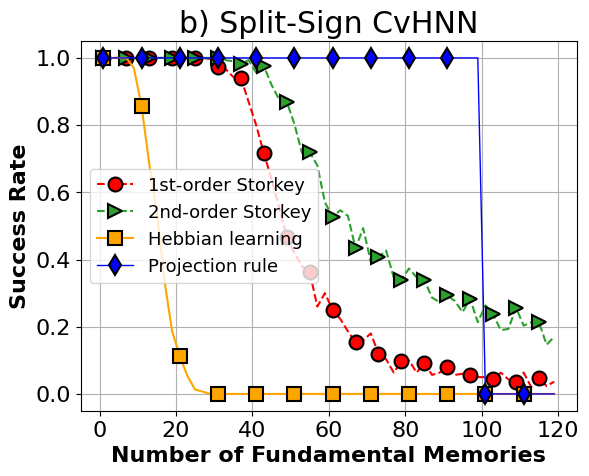

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [148]:
@load "JLDs/StorageCapacity_SplitSign.jld2"
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
font0 = Dict(
        "font.size" => 18,
        "axes.labelweight" => "bold",
        "axes.labelsize" => 16,
        "xtick.labelsize" => 16,
        "ytick.labelsize" => 16,
        "legend.fontsize" => 13,
)
merge!(rcParams, font0)
plot(Pv,Success[1,:]/Nsim,linewidth=1.5,color="red",linestyle ="dashed", marker="o",markersize = 10,
    markevery=3,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "1st-order Storkey")

plot(Pv,Success[2,:]/Nsim,color="#2ca02c",linestyle ="dashed", marker=">",markersize = 10,
    markevery=3,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "2nd-order Storkey")

plot(Pv,Success[3,:]/Nsim,color="orange",linestyle ="solid", marker="s",markersize = 10,
    markevery=5,markeredgewidth=1.5, markeredgecolor=(0,0,0),label = "Hebbian learning")

plot(Pv,Success[4,:]/Nsim,linewidth=1,color="blue",linestyle ="solid",markersize = 10,
    markevery=5,markeredgewidth=1.5, markeredgecolor=(0,0,0), marker="d",label = "Projection rule")

legend()
grid()

xlabel("Number of Fundamental Memories")
ylabel("Success Rate")
title("b) Split-Sign CvHNN")

savefig("Figures/StorageCapacity_SplitSign.eps",bbox_inches="tight")
savefig("Figures/StorageCapacity_SplitSign.pdf",bbox_inches="tight")

In [147]:
[maximum(Pv[Success[i,:].>=300*0.99]) for i=1:4]

4-element Array{Int64,1}:
 29
 39
  7
 99